# Moire pattern visualization guide
***
Code is available at https://github.com/JoMH-Git/moire_visualization
***

This tutorial showcases how to use this tool for visualizing Moire patterns of stacked 2d/quasi 2d materials.

The tutorial is devided into the following chapters:

1) Building the structure using the ASE library

2) Simple Moire visualization of 3d objects by casting to 2d surface

3) HRTEM image simulation using abtem visualization software

4) STEM image simulation using abtem visualization software


Section 1 and 2 are developed using ASE and matplotlib with the option to use structures directly from materials project database using their native api (mp_api.client).

The visualizations in section 2 visualizes images in real space focued on fast calculation time more so than accurate representation of TEM images

Section 3 and 4 uses the ABTEM library for more accurate simulation outcomes, but comes with the cost of increased calculation times.


As a general comment, one should consider the method used depending on the knowledge and needed accuracy. Even though ABTEM is a state-of-the-art TEM simulation tool, one should know that the physics are complicated, thus design choices when setting up the simulation can have vast impacts on the simulation outcomes and thus on the accuracy of the simulation. For simplicity and ease of use, several parameters are pre-defined, such as the microscopes defocus setting, desired resolution and the choice of not implementing any atomic vibrational motion / noise factors. For the experienced user or for the user with desires of getting the most realistic simulation outcomse as possible, I recomend to check out https://abtem.readthedocs.io/ . More advanced features can easily be implemented on top of this tool if desired.

In [1]:
from ipynb.fs.full.Abtem_lib import *

from mp_api.client import MPRester #for connecting to Materials Project API
from pymatgen.io.ase import AseAtomsAdaptor #for converting pymatgen structure to ASE atoms object
from ase.visualize import view #for visualizing the ase structures
import ase #for manipulating the ase atoms object
from ase.io.trajectory import Trajectory
import math
import abtem
import numpy as np
from tqdm import tqdm
import os
import abtem
import pandas as pd
import plotly.express as px

# 1) Building the struture using the ASE library

We start by first building the unitcell

For loading a structure, one can either use the Material Project Database or make it with the parameters given for the unitcell. 
As an exampel structure the SrTiO3 structure is used:

In [2]:
# If you want to use the structure from Materials Project, you need your personal API key and the materials ID


#SrTiO3_MP_ID = "mp-5229"
#srtio3_unitcell = get_structure_from_MPR(SrTiO3_MP_ID, api_key = "enter your API key here")

otherwise, you can make the structure from scratch given the lattice parameters and atomic positions

In [3]:

#unit cell parameters
a=3.905

atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]

spacegroup = 221

#size of the unit cell
size = (1,1,1)

srtio3_unitcell = ase.spacegroup.crystal(['Sr','Ti','O'] ,basis=atom_pos, spacegroup=spacegroup ,
                           cellpar=a, size=(1,1,1))

#lets visualize the structure
from ase.visualize import view
view(srtio3_unitcell, viewer="x3d")

If a specific surface cut is desired, the specific miller indicies can be specified

In [4]:

#miller indices of the surface we want to cut
miller_indices = (1,1,1)
layers = 2 #number of repetitions/layers in the slab in the z direction
tol = 1e-10 #The maximum distance in Angstrom along the plane normal for counting two atoms as belonging to the same plane.

#The cell can be made from the base unitcell using the ase.build.surface function
srtio3_miller_cut =  ase.build.surface(srtio3_unitcell, indices = miller_indices, layers=layers, vacuum=None, tol=tol, periodic=True)
view(srtio3_miller_cut, viewer="x3d")

ase with ase the structure can easily be repeated. Below is shown a repetions of both the standard unitcell repeated 10 times in X and Y as well as the (1 1 1) cut slab cell.

In [5]:
#repeatitions of the unit cell in the x, y and z directions
rep = (10,10,1)

#make the supercell
srtio3_supercell_standard = srtio3_unitcell.repeat(rep)

#visualize the supercell
view(srtio3_supercell_standard, viewer="x3d")


In [6]:
#visualize the supercell with the Miller cut
srtio3_supercell_miller = srtio3_miller_cut.repeat(rep)
view(srtio3_supercell_miller, viewer="x3d")

Now, to get proper moire patterns, we need a supercell large enough to get the moire pattern.

We can use the function create_supercell to get a supercell large enough to have a square segment with the same center given any rotation around the Z axis.

We can then use the cut_supercell to get the square segment with the option to add a rotation or translation if desired.

This will give a square supercell with a minimum extent of __ [Å] in the X and Y direction respectively.

*** 
*Bear in mind that the cell vectors 1 and 2 should have no Z component for the sqript to work.*
*You therefore should make sure you have defined your unitcell in this way for proper results.* 
*Be extra carefull when you import unitcells from MP database, as there are severeal here with non-zero Z-componetns for the first 2 unit-vectors.*
***


The supercell is on purpose made larger than the extent to allows the super cell to be rotated around it's center whithout the cut-section exeeding the edge of the supercell.

Moreover, translation in the X and Y directions can also be added as parameters to the cut_supercell function. This moves the center of the cut-section by the specified amount in Angstroms.
***
*Bear in mind that when cutting the supercell, the periodic boundary conditions are no longer taken into considerations.*
***


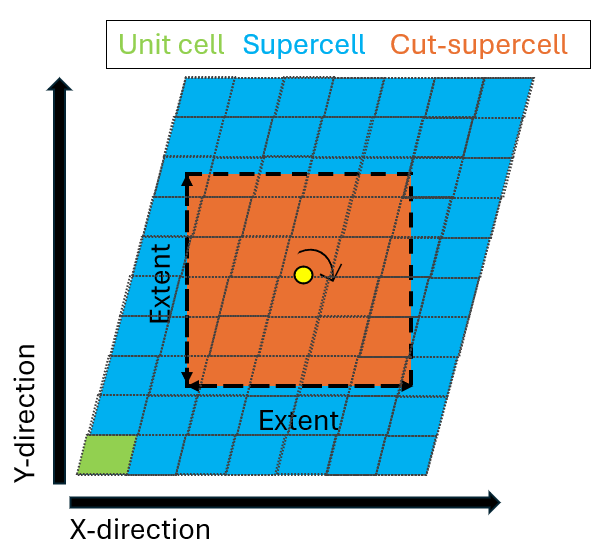

In [ ]:

extent_min = 30 #minimum extent of supercell in angstroms


#making supercell of the standard unitcell
supercell_standard = create_supercell(srtio3_unitcell, extent=extent_min)

#cutting the supercell to make a square layer of the supercell with a given rotation and translation
layer1 = cut_supercell(supercell_standard, extent=extent_min, theta=30, X_translation = 0, Y_translation = 0)


#Now, to make a second layer, you can do the same thing on another surface, in this case we use the cut slab from earlier

#making supercell of the cut slap
supercell_miller = create_supercell(srtio3_miller_cut, extent=extent_min)
#cutting the supercell to make a square layer of the supercell with a given rotation and translation
layer2 = cut_supercell(supercell_miller, extent=extent_min, theta=0, X_translation = 1.5, Y_translation = 1.5)


<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Cut supercell of (1 1 1) SrTiO3 surface translated 1.5 Å in both X and Y'}, xlabel='x [Å]', ylabel='y [Å]'>)

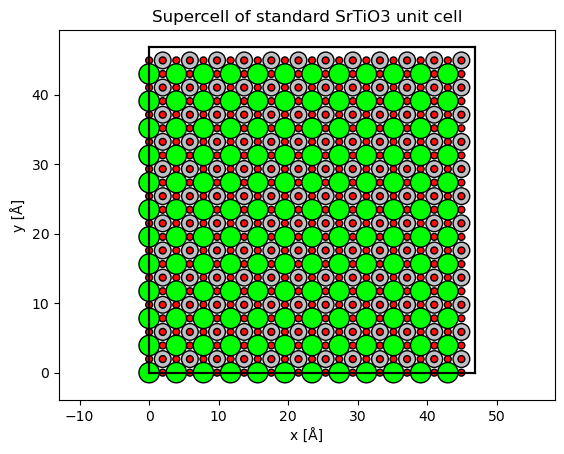

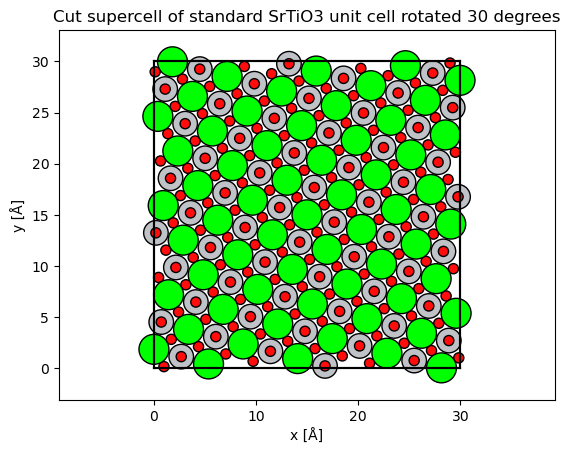

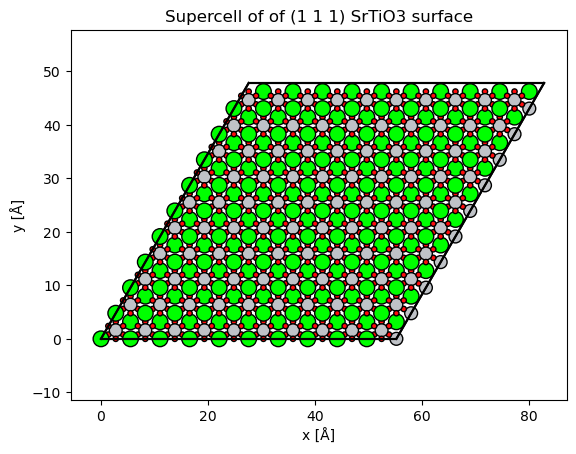

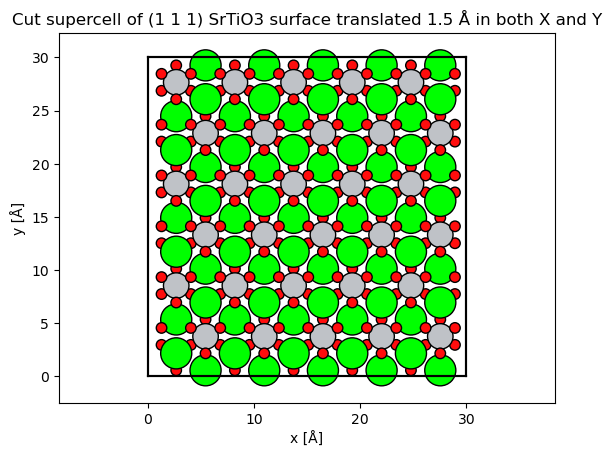

In [ ]:
#visualizing the supercell and the cut layers
abtem.visualize.visualizations.show_atoms(supercell_standard, plane='xy', ax=None, scale=0.75, title="Supercell of standard SrTiO3 unit cell", numbering=False, show_periodic=False, 
                                          figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)

abtem.visualize.visualizations.show_atoms(layer1, plane='xy', ax=None, scale=0.75, title="Cut supercell of standard SrTiO3 unit cell rotated 30 degrees", numbering=False, show_periodic=False, 
                                          figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)
abtem.visualize.visualizations.show_atoms(supercell_miller, plane='xy', ax=None, scale=0.75, title="Supercell of of (1 1 1) SrTiO3 surface", numbering=False, show_periodic=False, 
                                          figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)

abtem.visualize.visualizations.show_atoms(layer2, plane='xy', ax=None, scale=0.75, title="Cut supercell of (1 1 1) SrTiO3 surface translated 1.5 Å in both X and Y", numbering=False, show_periodic=False, 
                                          figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)

To combine the structures, the function combine_layers is used.
Bear in mind that the distance between layers is set to 1Å by default

In [9]:
Structure_1 = combine_layers(layer1, layer2, interlayer_distance=1.0, xy_padding=3, z_padding=1.0)

Make sure your supercell is oriented in the direction you want. 

The Moire Pattern of the supercell will be displayed in the xy plane (corresponding to TEM being taken along the Z axis)

Layer 1 will always be the one that is closesed to the probe.

If using the HRTEM and STEM function developed for testing multiple twist angles, layer 2 is always the one where twists and translations are performed on

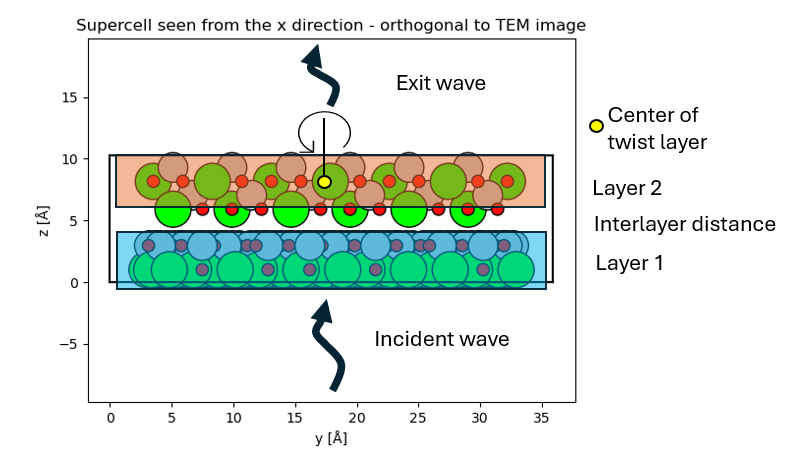
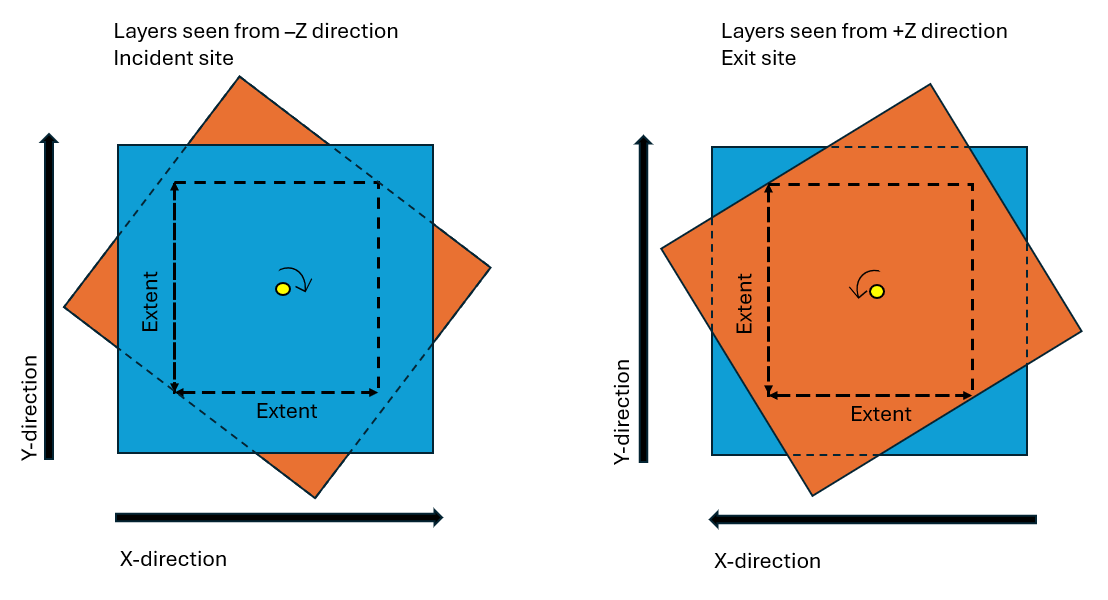

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Supercell seen from the x direction - orthogonal to TEM image'}, xlabel='y [Å]', ylabel='z [Å]'>)

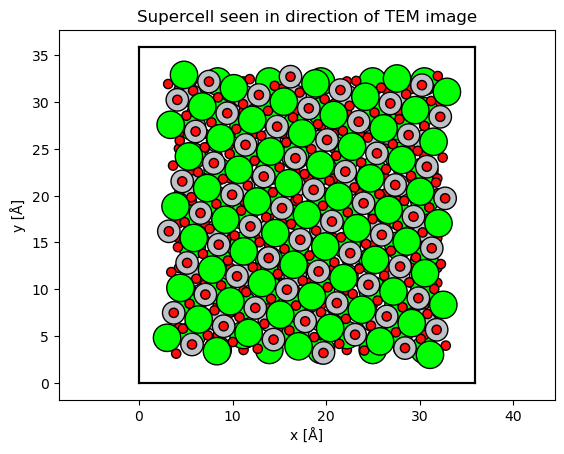

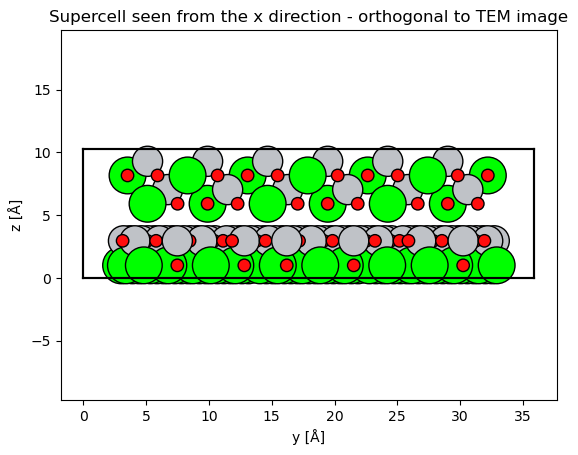

In [10]:
import abtem
abtem.visualize.visualizations.show_atoms(Structure_1, plane='xy', ax=None, scale=0.75, title="Supercell seen in direction of TEM image", numbering=False, show_periodic=False, 
                                          figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)
abtem.visualize.visualizations.show_atoms(Structure_1, plane='yz', ax=None, scale=0.75, title="Supercell seen from the x direction - orthogonal to TEM image", numbering=False, show_periodic=False, figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)

# 2) Simpel visualization of atomic strucures

This approach is for fast and simpel visualization of atmoic structures by casting the atoms onto a 2D plane.

The respective size of the strucures in the 2D space is relative to the atomic structure and the pixels in the image.

This is thus not an accurate representation, but does give an representation of the Moire-pattern that would be found in a TEM image. 

To make this work, you need to create 2 super-cell first.

In [11]:
extent_min = 30 #minimum extent of supercell in angstroms


#making supercell of the standard unitcell
supercell_standard = create_supercell(srtio3_unitcell, extent=extent_min)


#making supercell of the cut slap
supercell_miller = create_supercell(srtio3_miller_cut, extent=extent_min)


Next, we have to make a list of the rotation angles we want to animate

In [12]:
#defining the angular range and resolution
theta_max = 90
theta_min = 0
step=0.5
theta = np.arange(theta_min, theta_max+step, step)


We are using Plotly Express to make the anumation. This is done using a dataframe. This dataframe is generated using the "generate_plotdata" function:

In [13]:
plotting_data = generate_plotdata(supercell_1= supercell_standard, supercell_2= supercell_miller, theta= theta)

The dataframe is very large, but it is still quite quick to make and to plot

In [14]:
np.shape(plotting_data)

(311320, 7)

To plot the data we use the "create_custom_scatter_plot" function. You can play around with the parameters. Below is 2 examples of how the plots can look:

In [ ]:
fig_1 = create_custom_scatter_plot(plotting_data, extent=extent_min, title = "Scatter plot of 001 on 111 facet", size=0.25, color_column="species", hover_column="layer", color_sequence=['green', 'grey', 'red'])
fig_1.show()

In [ ]:
fig_2 = create_custom_scatter_plot(plotting_data, extent=extent_min,  title = "Scatter plot of 001 on 111 facet", size=0.3, color_column="species", hover_column="layer", color_sequence=['white'], paper_bgcolor='lightgrey', plot_bgcolor='black')
fig_2.show()

# 3) HRTEM image simulation

HRTEM means High Resolution Transmission Electron Microscopy. The main difference between how HRTEM and STEM is WHEN the beam is focused by an objective lense. In HRTEM the electron beam is focused AFTER the electrons have interacted with the speciement whereas the beam in STEM is focused BEFORE the interaction with the speciement. This makes a big difference as HRTEM thus coveres a greater area of the speciement with less electrons but at a cost of less detail at each specific point.
In the image below, CTEM is the same as HRTEM.

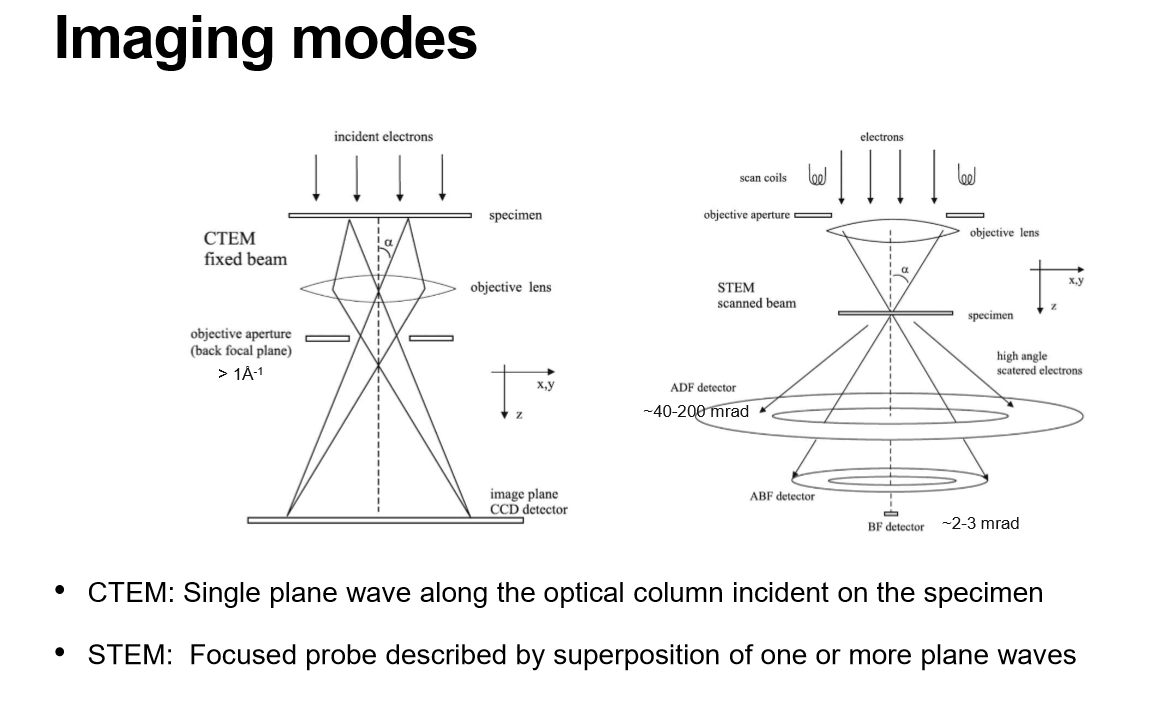

Simulation outcomes are saved in an object type called an abtem waves stack, where each electron exit wave is saved with the corresponding metadata labels of twist angel, x-translation and y-translation.
The waves stack object allow for easy, fast and interactive visualization of many paramterers, both in real space as well as in reciprocal/Fourier space.

Lets take an exampel where we want to simulate HRTEM 2 stacked SrTiO3 layers.
We use the building paramteres (unitcell of layer 1/2, extent, rotations and X/Y translations ) as well as TEM specefic paramteres.

The first TEM specific parameter is the **energy** of the electron wave - generallly speaking, the greater the energy, the faster the wave and the smaller the scattering.

- Smaller energies (~ 80keV) can therefore be used on sampels with smaller thickness and to visualize atoms with less dense cores / elements in the 2nd row in the periodic table 
- Larger energies (200-300 keV) can be used on thicker sampels as well as to reduce the influence of the smaller atoms on the image. Bear in mind that greater energy of the electron wave can damage the structres investigated in real life.

Secondly, one should define the **Slice thickness** and **resolution** as well.

**Slice thickness** is the thickness of each slice which the combined structure is cut for the ABTEM Multislice simulation - This method colapeses all the electric potentials in the z-axis of that specific point in the x-y dimension. This alows for faster simulations with still reasonably accurate simulation outcomes. The slice thickness is by default set to 0.5Å, which is a resonable assumption for many unitcells, however, this paramter should be chosen to match where atoms lie in the structure most accurately.

**Resolution** is the lowest length given in Å of which you can expect to see features of in the final image. The default length is 0.5Å, which is comparable to atoms with radii of ~1Å.

The script calcualtes sampling paramters by default based of nyquist sampling and anti-aliasing given these paramteres.

When the script runs, each layer is build before being combined and the potentail being calculated. The exit wave is then calculated using the multislice method given an electron beam with the given energy.

For simplicity, it is assumed that all the electrons have the exact energy specifed, although ABTEM has methods for implementing a spread of energies.

Lets do an exampel given the unitcell of SrTiO3:


In [17]:
#first we make an array of the angles we want to simulate
import numpy as np
theta_max = 15 #maximum tilt angle in degrees
theta_step = 3 #simulation in steps of 3 degrees
Theta_list = np.arange(0,theta_max+theta_step,theta_step)

#if translations are wanted, we can define the translation in the x and y direction
X = [0,0.5, 1] #simulate 0 and 2 Å shift in the x direction
Y = [0,0.5, 1] #simulate 0 and 2 Å shift in the y direction

#now for the supercell parameters
#in this case, we will use the same unit cell for both layers, but you can use different unit cells if you want to
unitcell_1 = srtio3_unitcell.copy() #unit cell of the material
extent  = 30 #extent of the supercell in angstroms
interlayer_distance = 1.5 #distance between layer 1 and layer 2 in angstroms
xy_padding = 2 #vaccum padding in the xy direction in angstroms - for avoiding potential overlap between layers
z_padding = 1.5 #vaccum padding in the z direction in angstroms - for avoiding potential overlap between layers

#lastly TEM specific parameters for making calculating the exit wave
energy = 150e3 #electron beam energy in eV
resolution = 0.25 #resolution of finest features resolved in angstroms
slice_thickness = 0.5 #thickness of the multislice slices in angstroms


In [18]:
#Now lets create the exit wave:
#it may take a few minutes, depending on the size of the supercell and the number of angles you want to simulate
exit_waves, metadata = gen_stack_from_unitcell(unit_cell_layer1 = unitcell_1,  Theta = Theta_list, extent = extent, 
                                interlayer_dist=interlayer_distance, xy_padding = xy_padding, z_padding = z_padding,
                                X_translation = X, Y_translation = Y, sliceThickness = slice_thickness,
                                resolution = resolution, energy = energy)
#if unit_cell_layer2 is not specified, unit_cell_layer1 is used for both layers by default

Angle number::   0%|          | 0/6 [00:00<?, ?it/s]


[########################################] | 100% Completed | 5.64 ss


[########################################] | 100% Completed | 4.04 ss


[########################################] | 100% Completed | 4.35 ss


[########################################] | 100% Completed | 3.80 ss


[########################################] | 100% Completed | 4.00 ss


[########################################] | 100% Completed | 3.15 ss


[########################################] | 100% Completed | 4.48 ss


[########################################] | 100% Completed | 3.85 ss


[########################################] | 100% Completed | 3.14 ss




Angle number::  17%|█▋        | 1/6 [00:38<03:10, 38.04s/it]


[########################################] | 100% Completed | 2.97 ss


[########################################] | 100% Completed | 4.01 ss


[########################################] | 100% Completed | 3.88 ss


[########################################] | 100% Completed | 2.93 ss


[########################################] | 100% Completed | 2.83 ss


[########################################] | 100% Completed | 3.05 ss


[########################################] | 100% Completed | 4.28 ss


[########################################] | 100% Completed | 3.85 ss


[########################################] | 100% Completed | 3.14 ss




Angle number::  33%|███▎      | 2/6 [01:09<02:16, 34.12s/it]


[########################################] | 100% Completed | 3.17 ss


[########################################] | 100% Completed | 4.21 ss


[########################################] | 100% Completed | 5.01 ss


[########################################] | 100% Completed | 3.68 ss


[########################################] | 100% Completed | 3.65 ss


[########################################] | 100% Completed | 4.07 ss


[########################################] | 100% Completed | 3.94 ss


[########################################] | 100% Completed | 3.60 ss


[########################################] | 100% Completed | 3.08 ss




Angle number::  50%|█████     | 3/6 [01:44<01:43, 34.46s/it]


[########################################] | 100% Completed | 3.47 ss


[########################################] | 100% Completed | 3.84 ss


[########################################] | 100% Completed | 3.06 ss


[########################################] | 100% Completed | 2.83 ss


[########################################] | 100% Completed | 2.93 ss


[########################################] | 100% Completed | 3.45 ss


[########################################] | 100% Completed | 3.75 ss


[########################################] | 100% Completed | 3.07 ss


[########################################] | 100% Completed | 2.83 ss




Angle number::  67%|██████▋   | 4/6 [02:13<01:05, 32.54s/it]


[########################################] | 100% Completed | 3.07 ss


[########################################] | 100% Completed | 4.97 ss


[########################################] | 100% Completed | 3.65 ss


[########################################] | 100% Completed | 2.63 ss


[########################################] | 100% Completed | 2.63 ss


[########################################] | 100% Completed | 2.75 ss


[########################################] | 100% Completed | 3.44 ss


[########################################] | 100% Completed | 3.34 ss


[########################################] | 100% Completed | 2.73 ss




Angle number::  83%|████████▎ | 5/6 [02:43<00:31, 31.48s/it]


[########################################] | 100% Completed | 3.81 ss


[########################################] | 100% Completed | 4.68 ss


[########################################] | 100% Completed | 4.40 ss


[########################################] | 100% Completed | 3.34 ss


[########################################] | 100% Completed | 2.73 ss


[########################################] | 100% Completed | 3.07 ss


[########################################] | 100% Completed | 4.51 ss


[########################################] | 100% Completed | 4.64 ss


[########################################] | 100% Completed | 3.14 ss


Creating the exit wave stack...
Done!


The exit waves can be visualized themselves before applying the lense

To visualize the results using abtems interactive visualization tool, one need to have installed the ipympl matplotlib backend and activate it.

The results can be shown as either real space or in reciprocal space

In [19]:
#activate Notebook visual backend to enable interactive visualizations
%matplotlib ipympl
#to use the interactive plots, one should set interact=True

#plot outcomes in real space
exit_waves.show(interact=True, cbar= True)
#plot outcomes in reciprocal space
exit_waves.diffraction_patterns().show(interact = True, cbar = True, power = 0.21)

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

Now, to get a simulation outcome most similar to what you would have in a real HRTEM image, we have to apply a **Contrast Transfer Function** (CTF). 

The CTF the aberrations of the objective lens in HRTEM and how the condenser system shapes the probe in STEM. In this case we focus on the HRTEM case.

The only 2 paramters considered in this scirpt are the **Spherical abberation** (Cs) and the **defocus** setting. One should note that the spehrical abberations are an artifact of the objective lense - 
It is thus microscope specific and is constant for a specific microscope. The defocus setting can be changed to compensate for some of the abberations.

In this script Cs = -50 μm, but abtem needs the value converted to angstrom

If you want to learn more about how abberations work and their effect on TEM imaging, it is suggested to read the abtem walkthrough on CTF. 
***
https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/contrast_transfer_function.html#walkthrough-contrast-transfer-function
***


In [20]:
Cs = -50e-6 * 1e10  # 50 micrometers spherical aberration converted to angstroms
# the defocus value is calculated by abtem using the scheizer defcus method
ctf = abtem.CTF(Cs=Cs, energy=energy, defocus="scherzer")

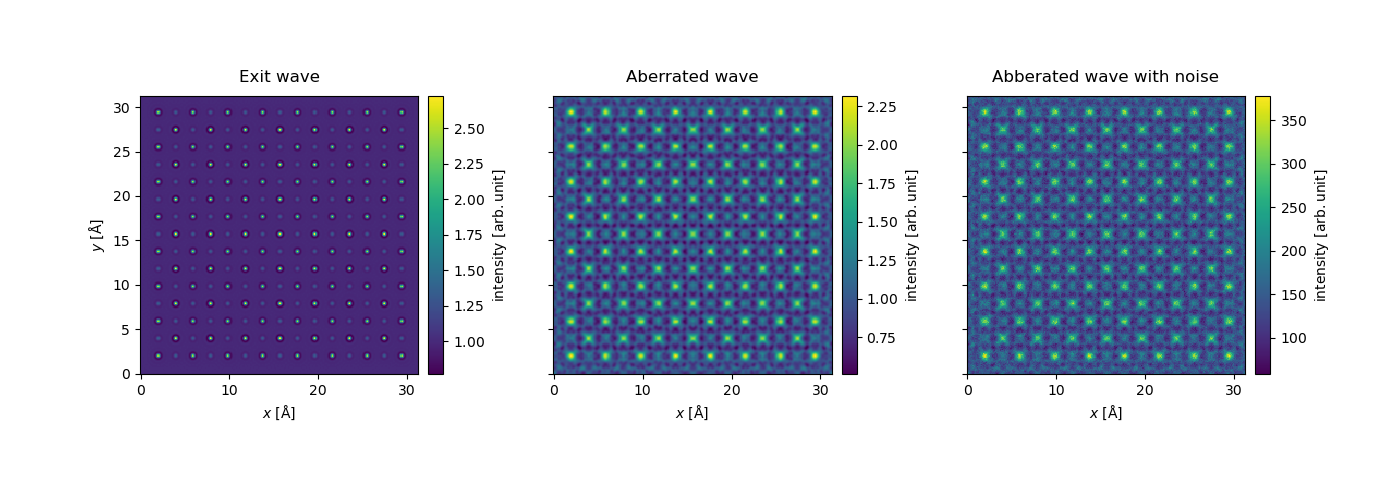

In [42]:
#lets visualize the exit wave and the aberrated wave and the abberated wave with noise

#the structure of the stack is (number of angles, number X-translations, number of Y-translations, abtem object).
#To get the the first angle (0 degrees twist), first translation in the x direction (0 Å shift) and first translation in the y direction (0 Å shift) we need to go to [0][0][0]

Exit_Wave = exit_waves[0][0][0].intensity()
Abberation = exit_waves[0][0][0].copy().apply_ctf(ctf).intensity()
Noise = Abberation.poisson_noise(dose_per_area=1e4)


# make sure to set the common_color_scale = False, otherwise the color scale 
abtem.stack([Exit_Wave, Abberation, Noise], ("Exit wave", "Aberrated wave", "Abberated wave with noise")).show(
    explode=True,
    figsize=(14, 5),
    common_color_scale=False,
    cbar=True,
)

In [22]:
#Now, this abberation can be added to all of the exit waves at once using the apply_ctf function
abberated_exitwaves = exit_waves.copy().apply_ctf(ctf)
#and now we can visualize the exit wave and the aberrated wave

#plot outcomes in real space
abberated_exitwaves.show(interact=True, cbar= True)
#plot outcomes in reciprocal space
abberated_exitwaves.diffraction_patterns().show(interact = True, cbar = True, power = 0.21)

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

You can also make the simulation on a coustom trajectory object made with ASE. Below is an example where the recunstruction of two 001 facets have been calculated using density functional theory (DFT). 

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Last frame'}, xlabel='y [Å]', ylabel='z [Å]'>)

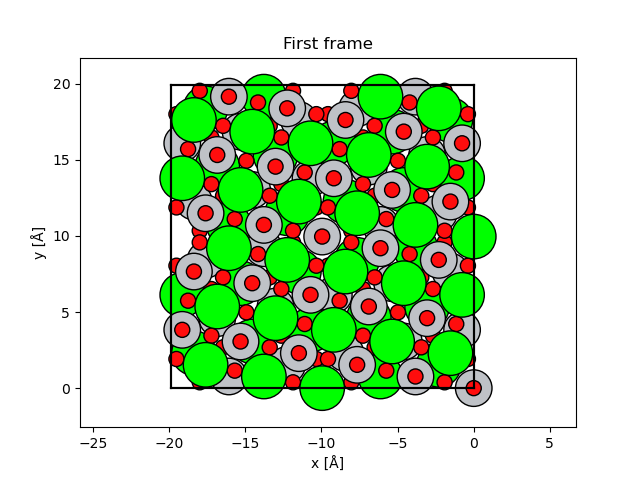

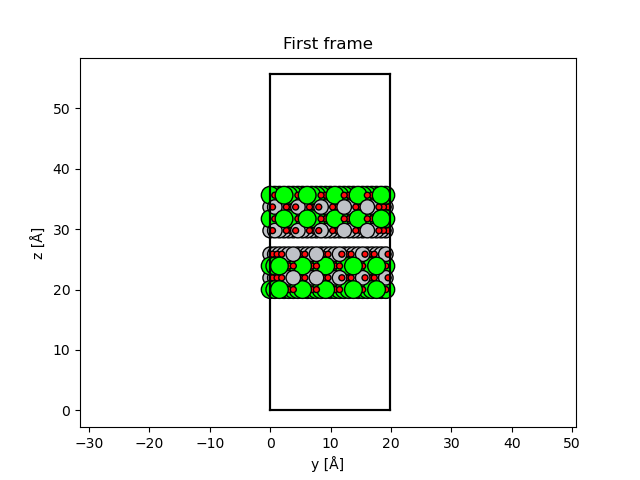

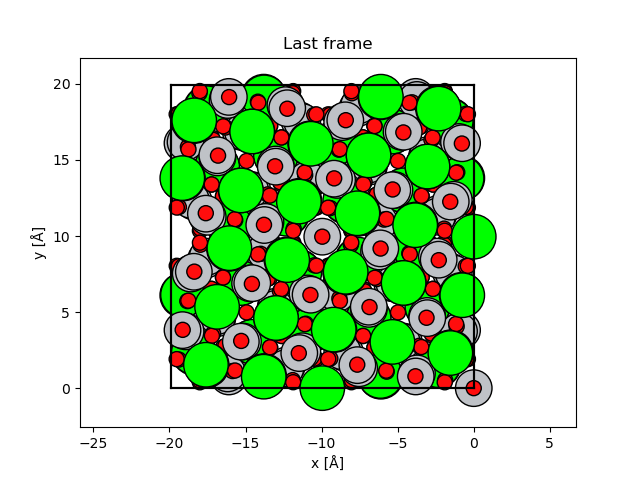

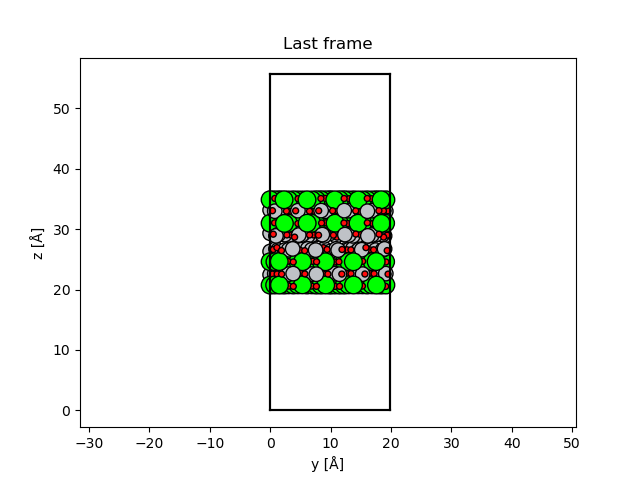

In [23]:
ase_traj  = Trajectory('SrTiO3DFT/full-relax-n-1-m-5.traj')
first_frame = ase_traj[0]
last_frame = ase_traj[-1]

#Visualizing first frane
abtem.visualize.visualizations.show_atoms(first_frame, plane='xy', ax=None, scale=0.75, title="First frame")
abtem.visualize.visualizations.show_atoms(first_frame, plane='yz', ax=None, scale=0.75, title="First frame")

#Visualizing last frame
abtem.visualize.visualizations.show_atoms(last_frame, plane='xy', ax=None, scale=0.75, title="Last frame")
abtem.visualize.visualizations.show_atoms(last_frame, plane='yz', ax=None, scale=0.75, title="Last frame")

In [ ]:
#definng the HRTEM parameters
sliceThickness = 1.0
resolution = 0.5
energy = 150e3

exitwave_traj, metadata_traj = gen_stack_from_trajectory(ase_traj, sliceThickness = sliceThickness, resolution =resolution, energy = energy)
   

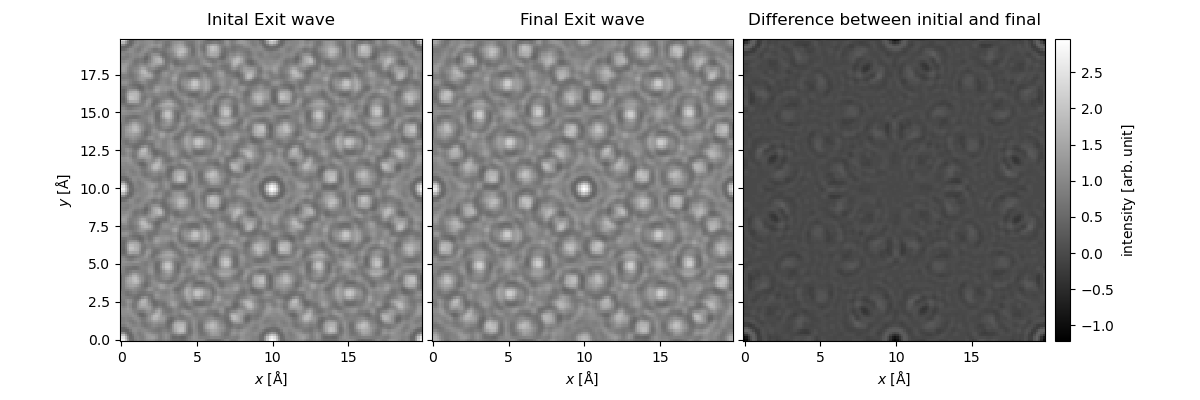

In [25]:
#lets visualize the exit wave and the aberrated wave and the abberated wave with noise


#construction the visalization of the first and last frame
Exit_Wave_traj_first = exitwave_traj[0].intensity()

Exit_Wave_traj_last = exitwave_traj[-1].intensity()

#calculating the difference between the first and last frame
dif_exit =  Exit_Wave_traj_last - Exit_Wave_traj_first

# make sure to set the common_color_scale = False, otherwise the color scale 
#you can make the plot interactive by setting interact=True
abtem.stack([Exit_Wave_traj_first,  Exit_Wave_traj_last, dif_exit],
            ("Inital Exit wave","Final Exit wave", "Difference between initial and final",)).show(
    explode=True,
    figsize=(12, 4),
    common_color_scale=True,
    cbar=True,
    power = 1.0,
    cmap='grey',
    interact = False
)


Lastly, you can save the outcomes to disk using the **save_outcome()** function. The file is saved as a zarr obeject in a folder called 'data'. You can choose to save the outcomes either as a waves object, or as a measurement object. Alternatively you can make a coustom file path using the '.to_zarr(directory, filename)' command directly on the abtem stack object

*Note: measurement obejcts take up less space, so it is recomended to save outcomes as measurements instead of exit waves. This is done by using the '.intensity()' command on the exit wave*


In [26]:
#save the abberated exit wave (measurement object) to disk
save_outcome(abtem_stack=abberated_exitwaves, filename="SrTiO3_001_rot_0_90_abberated_measurement")


[########################################] | 100% Completed | 105.32 ms
File has been saved to disk at directory:
 c:\Users\Bruger\Desktop\Python\Moire\moire_visualization\data\SrTiO3_001_rot_0_90_abberated_measurement


The structures can be loaded again using the 'abtem.array.from_zarr(file_directory)' command:

In [27]:
#lets load in and visualize the abberated wave
measurement_loaded = abtem.array.from_zarr('data/SrTiO3_001_rot_0_90_abberated_measurement')

measurement_loaded.show(interact=True, cbar= True)

[########################################] | 100% Completed | 105.61 ms


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

# STEM visualization

STEM is basically the HRTEM process done in reverse. It works by moving the Probe and focusing the beam onto a specific point on the structure.

A Probe object is used to create a Converge electron beam - This can be understood as the beam after it has gone thorugh the objective lense, but before it has reached the speciment.

The Probe object therefore needs the same parameters as the Plane Wave for the HRTEM (energy, extent, resolution) as well as the information for the contrast transfer function
(abberations, defocus setting, energy spread etc.) as well as potential semiangle cutoff (which is basically the size of the hole thorugh which the beam is emitted - this limits the maximum incident angle of the beam as the outermost beams that would otherwise be influenced the most by the objective lense will be stopped instead)

Lets make a an exampel probe fitted to exampel structure

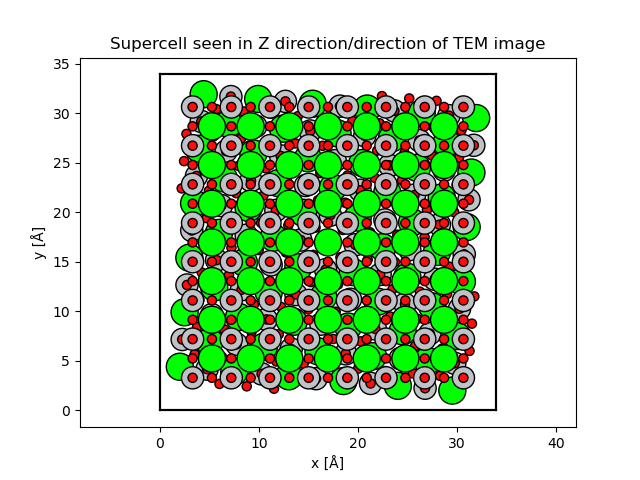

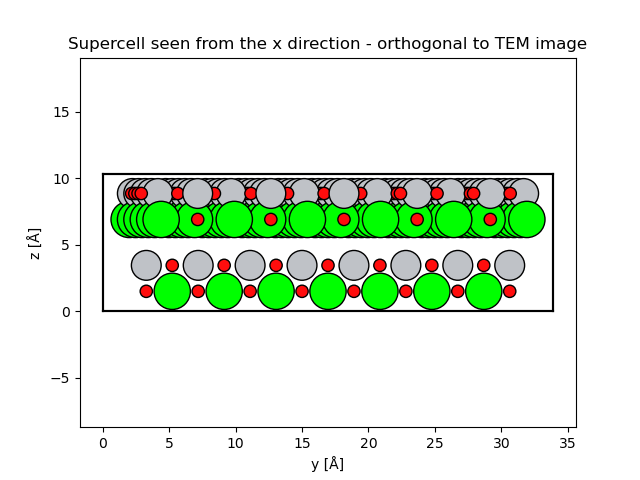

In [28]:
extent = 30  # extent of the probe in angstroms
resolution = 0.2  # resolution of the probe in angstroms
energy = 80e3  # electron beam energy in eV
Cs = -50e-6 * 1e10  # 50 micrometers spherical aberration converted to angstroms
xy_padding = 2  # vacuum padding in the xy direction in angstroms
z_padding = 1.5  # vacuum padding in the z direction in angstroms
interlayer_distance = 1.5  # distance between layer 1 and layer 2 in angstroms
theta_1 = 0  # rotation angle in degrees
theta_2 = 40  # rotation angle in degrees
x_translation_2 = 0  # translation in the x direction in angstroms
y_translation_2 = 0  # translation in the y direction in angstroms

semiangle_cutoff  = 50 # semiangle cutoff in mrad
slice_thickness = 1 #thickness of the multislice slices in angstroms

#Creating the structure
supercell_Layer = create_supercell(srtio3_unitcell,extent) #supercell from unit cell of the material

cut_supercell_Layer1 = cut_supercell(supercell_Layer, extent=extent, theta=theta_1, X_translation = 0, Y_translation = 0)
cut_supercell_Layer2 = cut_supercell(supercell_Layer, extent=extent, theta=theta_2, X_translation = 0, Y_translation = 0)
combined_supercell = combine_layers(cut_supercell_Layer1, cut_supercell_Layer2, interlayer_distance=interlayer_distance, xy_padding=xy_padding, z_padding=z_padding)

#plotting the supecell
scale = 0.7
abtem.visualize.visualizations.show_atoms(combined_supercell, plane='xy', ax=None, scale=scale, title="Supercell seen in Z direction/direction of TEM image", numbering=False, show_periodic=False, 
                                          figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)
abtem.visualize.visualizations.show_atoms(combined_supercell, plane='yz', ax=None, scale=scale, title="Supercell seen from the x direction - orthogonal to TEM image", numbering=False, show_periodic=False, figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None)


#calcualting the grid points from the extent and resolution
params = sampling_parameters(cut_supercell_Layer1, energy = energy, resolution = resolution)

gpts = params["gpts"] # grid points size in angstroms


#Now, well make the multislice potentials form the combined supercell
potential = potential_build(ase_structure = combined_supercell, energy = energy, 
                    slice_thickness = slice_thickness, parametrization="lobato", 
                    projection="finite", resolution=resolution, gpts=gpts)

# making the probe object
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    Cs= Cs
)
#making the probe extent match the extent of the potential
probe.grid.match(potential)


Given the infromation given, the nyquist sampling can be found:

In [29]:
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

Nyquist sampling = 0.209 Å/pixel


This is almost the same as the value calculated by the sampling_paramters function:

In [30]:
print(f"Nyquist sampling = {params['Pixel size']:.3f} Å/pixel") 

Nyquist sampling = 0.059 Å/pixel


When using abtem.GridScan in 2D, you can choose the area of the structure where you wish to scan. This is by giving a start and an end coordinate given in fractions of the total square cell.

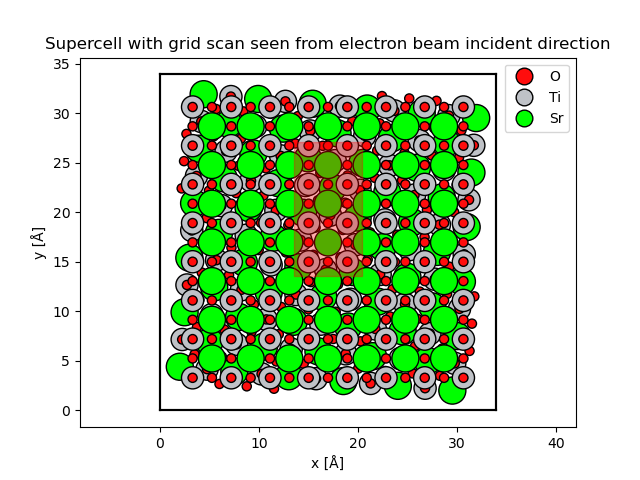

In [32]:
#defining the start and end points of the grid scan in fractional coordinates
start=[4/10, 4/10]
end=[6/10, 8/10]

#defining the grid scan object
grid_scan = abtem.GridScan(
    start=start,
    end=end,
    sampling=sampling,
    fractional=True,
    potential=potential,
)

#visualizing the grid scan area
fig, ax = abtem.show_atoms(combined_supercell, title = "Supercell with grid scan seen from electron beam incident direction", scale=0.7, legend=True)
grid_scan.add_to_plot(ax)

To have a visualization of the snippet, you can use the visualize_snippet function:

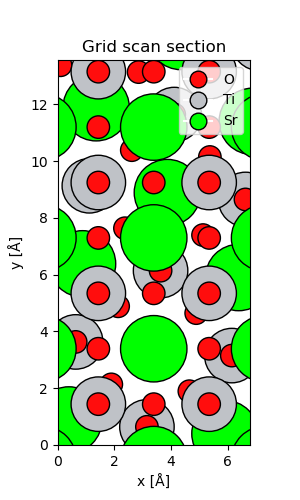

In [64]:
vis_atoms_fig, vis_atoms_ax = visualize_snippet(atoms = combined_supercell, start = [4/10, 4/10], end = [6/10, 8/10], 
                  title = "Grid scan section", scale=0.6, legend=True, figsize=[3,5], tight_limits=True)

We now set up the detectors as well

In [34]:
bright = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)
# combining the detectors into a list
all_detectors = [bright, maadf, haadf]


We can now make the STEM simulation to calcualte the exit wave

In [35]:
exit_waves_grid = probe.multislice(potential=potential, scan=grid_scan)
print(
    f"Maximum simulated scattering angle = {min(exit_waves_grid.cutoff_angles):.1f} mrad"
)

Maximum simulated scattering angle = 210.5 mrad


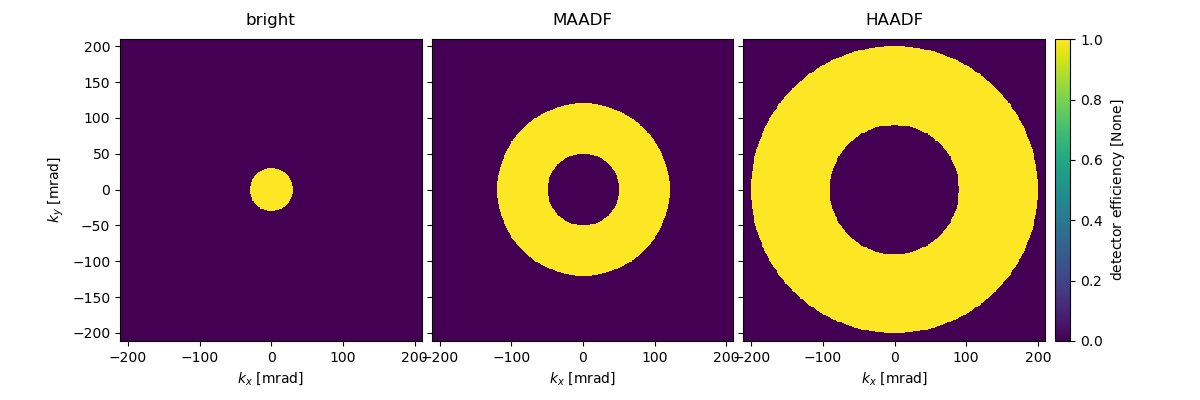

In [36]:
bright_region = bright.get_detector_region(exit_waves_grid)
maadf_region = maadf.get_detector_region(exit_waves_grid)
haadf_region = haadf.get_detector_region(exit_waves_grid)

stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF")
)

visualization = stacked_regions.show(
    explode=True, cbar=True, common_color_scale=True, units="mrad", figsize=(12, 4)
)

To make a measurement, you should add the detector:

In [37]:
measurements = probe.scan(
    potential, detectors=all_detectors, scan=grid_scan
).compute()

[########################################] | 100% Completed | 232.75 s


It is convenient to stack the measurements into a single Images object, so that they can be saved as a single file.

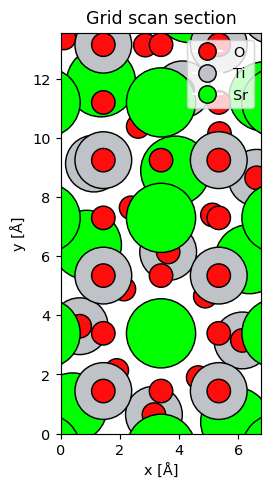

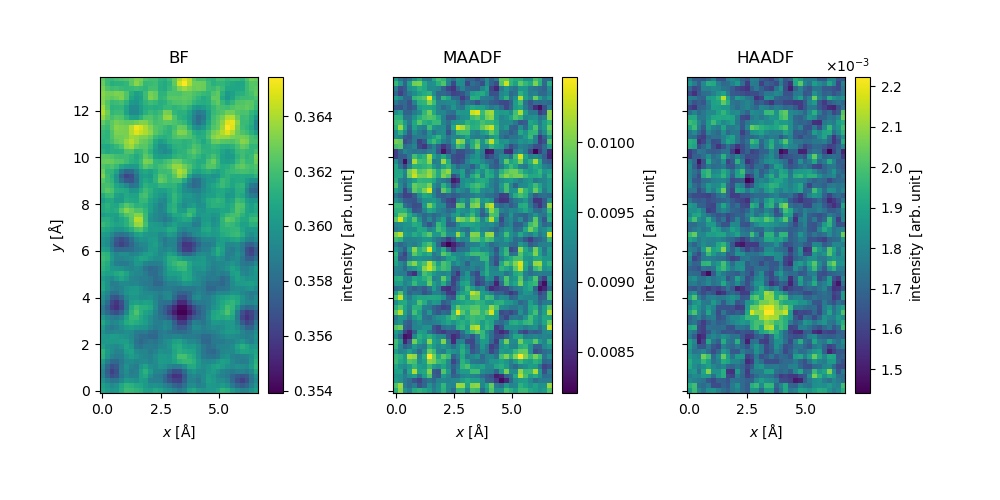

In [65]:
measurements = abtem.stack(measurements, ("BF", "MAADF", "HAADF"))
measurements.show(explode=True, cbar=True, figsize=(10, 5))
vis_atoms_fig

Now for the post-processing:

In [66]:
interpolated_measurement = measurements.interpolate(sampling=0.1)


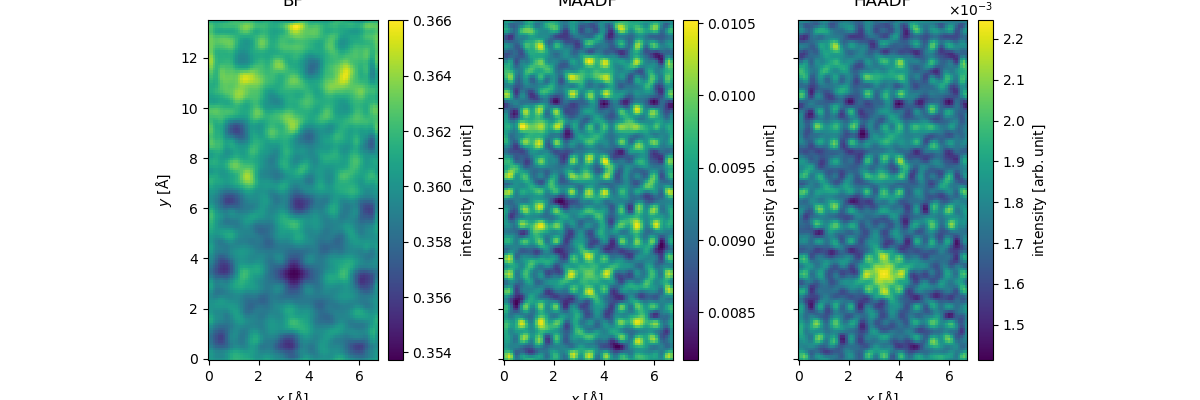

In [ ]:
visualization = interpolated_measurement.show(explode=True, cbar=True, figsize=(12, 4))

visualization.axes.set_sizes(cbar_spacing=1)

Blurring can also be added to simulate vibrations and other instabilities in the measurement. This is here done using a gaussian filter:

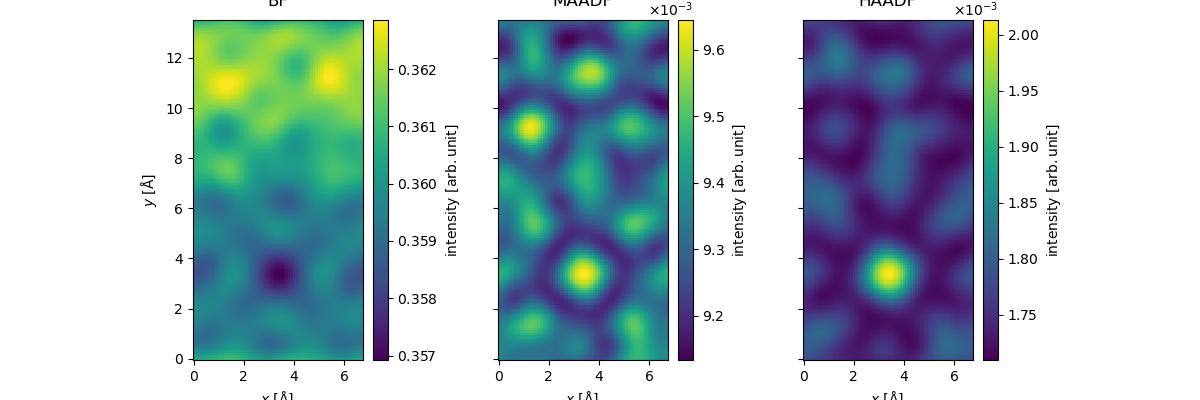

In [69]:
blurred_measurement = interpolated_measurement.gaussian_filter(0.5)
blurred_measurement.show(explode=True,  cbar=True, figsize=(12, 4))